--------------
# Playbook 7 : Capsule Network Performance
--------------
Evaluate Capsule Network Performance if p_dim and d_dim are varied.

## 1. Bring zipped data file across from gdrive to extract locally within colab

In [0]:
# Like a great many other libraries in Python, Keras is a mess of incompatability. 
# Need to use 2.2.4 or it breaks the CapsNet Code. I therefore standardise on 
# keras and tensorflow versions
!pip install gast==0.3.2
!pip install keras==2.2.4
!pip install tensorflow==1.15.2

In [0]:
%env GPATH=/content/gdrive/My Drive/MSc AI/Project/msccode

from google.colab import drive
drive.mount('/content/gdrive')
!cp "$GPATH/Datasets/processed-cell-images-malaria.zip" "processed-cell-images-malaria.zip"

env: GPATH=/tf/content/msccode


## 2. Remove existing dataset and extract dataset zip file

In [0]:
!rm -rf cell_images
!rm -rf dataset
!unzip -q 'processed-cell-images-malaria.zip'
!ls

## 3. Import required packages

In [0]:
#%tensorflow_version 1.15 

import os
import shutil
import numpy as np
import cv2
import tensorflow as tf
import numpy as np
import keras as keras
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks
from keras.utils.vis_utils import plot_model
import pickle
import sys

print(tf.__version__)
print(keras.__version__)

1.15.2
2.2.4


Using TensorFlow backend.


## 4. Define constants

In [0]:
IMG_SIZE = 44         # Data set images will be reframed to this width and height
TEST_FRACTION = 0.1   # Fraction of dataset to hold out for test purposes
VAL_SPLIT = 0.1       # Ammount of training data to use for validation
TEST_SPLIT = 0.1
BATCH_SIZE=32
EPOCHS=60

GPATH=os.environ['GPATH']

# Target image directory for 'processed' color images.
colorData = "./dataset/color/"
dstColorP = "./dataset/color/Parasitized/"
dstColorU = "./dataset/color/Uninfected/"

# Target image directory for 'processed' grayscale images.
grayData = "./dataset/gray/"
dstGrayP = "./dataset/gray/Parasitized/"
dstGrayU = "./dataset/gray/Uninfected/"

dataset_p_dirs=[dstColorP, dstGrayP]
dataset_u_dirs=[dstColorU, dstGrayU]

##5. Define function to load dataset into numpy arrays

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

def loadData(directory, labelMap, as_gray, quiet=True): 
    array_list = [] 
    label_list = []

    labels = [dn for dn in os.listdir(directory) if os.path.isdir(directory + '/' + dn)]

    for label in labels:
        classLabel = labelMap[label]
        subdir = directory + '/' + label
        files = [fn for fn in os.listdir(subdir) if fn.endswith(('.png'))] 
        print("Loading images for class {} from {}".format(classLabel, subdir))
        num_loaded = 0
        for img_file in files:
            file_path = subdir + '/' + img_file
            if as_gray is True:
                img = cv2.imread(file_path, 0)
            else:
                img = cv2.imread(file_path)
            img = img.astype('float32')
            array_list.append(img)
            label_list.append(classLabel)
            num_loaded += 1
            if not quiet:
                if num_loaded % 1000 == 0:
                    print("Loaded %d (of %d)..." %(num_loaded, len(files)))
        print("Completed loading %d (of %d) images" %(num_loaded, len(files)))
        print("")
        
    data = np.array(array_list)
    data /= 255.0
    return data, np.array(label_list)

def load_and_split_data(labelMap={"Uninfected": 0, "Parasitized":1},
                        gray=True, 
                        val_split=VAL_SPLIT, 
                        test_split=TEST_SPLIT):
    print("load_and_split_data called with Val/Test split fraction {}/{}".format(val_split, 
                                                                                 test_split))

    if gray: 
        data_X, data_Y  = loadData(grayData, labelMap, as_gray=True)
    else:
        data_X, data_Y  = loadData(colorData, labelMap, as_gray=False)
    idx = np.random.permutation(len(data_X))
    data_X, data_Y = data_X[idx], data_Y[idx]

    val_X = None; val_Y=None
    test_X = None; test_Y=None
    train_X = data_X; train_y = data_Y

    if test_split > 0:
        train_X, test_X, train_Y, test_Y = train_test_split(data_X, 
                                                            data_Y, 
                                                            test_size=test_split, 
                                                            stratify=data_Y)
    if val_split > 0:
        train_X, val_X, train_Y, val_Y = train_test_split(train_X, 
                                                          train_Y, 
                                                          test_size=val_split, 
                                                          stratify=train_Y)
    if gray:
        train_X = train_X.reshape(-1, IMG_SIZE,IMG_SIZE, 1).astype('float32')
        if val_split > 0:
            val_X = val_X.reshape(-1,IMG_SIZE,IMG_SIZE, 1).astype('float32')
        if test_split > 0:
            test_X = test_X.reshape(-1,IMG_SIZE,IMG_SIZE, 1).astype('float32')
    else:
        train_X = train_X.reshape(-1, IMG_SIZE,IMG_SIZE, 3).astype('float32')
        if val_split > 0:
            val_X = val_X.reshape(-1,IMG_SIZE,IMG_SIZE, 3).astype('float32')
        if test_split > 0:
            test_X = test_X.reshape(-1,IMG_SIZE,IMG_SIZE, 3).astype('float32')  

    print("Training data set size is", train_X.shape, train_Y.shape)
    if val_split > 0:
        print("Validation data set size is",val_X.shape, val_Y.shape)
    if test_split > 0:
        print("Test data data set size is",test_X.shape, test_Y.shape)

    labels, counts = np.unique(train_Y, return_counts=True)
    print("Training data labels and counts are", labels, counts)
    if val_split > 0:
        labels, counts = np.unique(val_Y, return_counts=True)
        print("Validation data labels and counts are", labels, counts)
    if test_split > 0:
        labels, counts = np.unique(test_Y, return_counts=True)
        print("Test data labels and counts are", labels, counts)

    return (train_X, train_Y, val_X, val_Y, test_X, test_Y)

##6. Define functions some utility functions for model performaance and accuracy

###6.1 Define function to plot model performance

In [0]:
import matplotlib.pyplot as plt

def plotModelPerf(history, sup = None, file=None):
    # Plot model training and validation loss and accuracy on one graph
    # history is an object provided by a fit() operation on a model
    
    print("Plotting Model accuracy and loss versus epoch")

    length = len(history.history["loss"])
    plt.style.use("ggplot")
    fig = plt.figure(figsize=(8,5))
    for key in history.history.keys():
        if 'caps' in key:
            plt.plot(np.arange(0, length), history.history[key], label=key)    
    if sup is None:
        plt.title("Training Loss and Accuracy", y = 1.05, fontsize=12)
    else:
        plt.title("Training Loss and Accuracy: ({})".format(sup), y = 1.05, fontsize=12)

    plt.xlabel("Epoch #") 
    plt.ylabel("Loss/Accuracy") 
    plt.legend()

    plt.tight_layout()
    plt.show()

    if file is not None:
        fig.savefig(file)

###6.2 Define function to calculate model accuracy

In [0]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

def getScores(model, test_X, test_Y):
    # Evaluate the model against the test data set.
    test_YC = keras.utils.np_utils.to_categorical(test_Y)

    results = model.evaluate([test_X, test_YC], [test_YC, test_X], verbose=0) 

    loss = results[0]
    accuracy = results[3]

    resultsProb = model.predict([test_X, test_YC], verbose=0) 
    results = np.argmax(resultsProb[0], axis=1) 

    precision = precision_score(test_Y, results, average='binary')
    recall = recall_score(test_Y, results, average='binary')
    f1 = f1_score(test_Y, results, average='binary')
    return (loss, accuracy, precision, recall, f1)

def showScores(scores):
    loss, accuracy, precision, recall, f1 = scores

    print("")
    print("Scores for classification model")   
    print("| %-8s | %-8s | %-9s | %-8s | %-8s"%
          ("Loss", "Accuracy", "Precision", "Recall", "F1"))
    print("| %-8s | %-8s | %-9s | %-8s | %-8s"%
          ('-' * 8, '-' * 8, '-' * 8, '-' * 8, '-' * 8)) 
    print("| %-8.3f | %-8.3f | %-9.3f | %-8.3f | %-8.3f"% 
          (loss, accuracy, precision, recall, f1))
      
def showModelScores(model, test_X, test_Y):
    scores = getScores(model, test_X, test_Y)
    showScores(scores)
    return scores

###6.3 Define wrapper function for model training

In [0]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from numpy.random import seed
import random as rand

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
rand.seed(12345)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.set_random_seed(1234)

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
seed(11)
(train_X, train_Y, val_X, val_Y, test_X, test_Y) = load_and_split_data(gray=False)
train_YC = keras.utils.np_utils.to_categorical(train_Y)
val_YC = keras.utils.np_utils.to_categorical(val_Y)
test_YC = keras.utils.np_utils.to_categorical(test_Y)

def trainModel(bestFile, model, opt, trainX, trainY, valX, valY, batch, nepochs, 
               verbose=1, 
               es=True):  
    '''
    Define some early stopping conditions. The first one insists a model does better
    than ~51% by the end of one epoch otherwise don't bother. Experience with training
    indicates if a model does not do better than this at the end of one epoch it tends
    to just sit around 50% after each epoch and just does not make progress.
    '''
    cbs = []
    if es is True:
        patience = nepochs//3
        if patience < 10:
            patience = 10
        es1 = EarlyStopping(monitor='out_caps_acc', verbose=verbose, baseline=0.508, patience=1)
    #    es2 = EarlyStopping(monitor='out_caps_acc', mode='max', verbose=verbose, baseline=0.70, patience=patience)
    #    es3 = EarlyStopping(monitor='out_caps_loss', mode='min', verbose=verbose, patience=patience)
        cbs = [es1]

    if bestFile is not None:
        cbs.append(ModelCheckpoint(bestFile, 
                                   monitor='val_out_caps_loss', 
                                   mode='min', 
                                   save_best_only=True))

    model.compile(optimizer=opt,
                  loss=[margin_loss, 'mse'],
                  loss_weights=[1., 0.0005],
                  metrics=['accuracy'])

    history = model.fit([trainX, trainY], 
                        [trainY, trainX], 
                        batch_size=batch, 
                        epochs=nepochs,
                        callbacks=cbs,
                        validation_data=[[valX, valY], [valY, valX]])
    return history
  
def CapsTest(k, 
             frac, 
             bs, 
             epochs, 
             f_sizes=[256,256], 
             p_dim=8, 
             d_dim=16,
             sc=2,
             mshow = False, 
             es=True,
             plot = True,
             bestFile = None, 
             pltFile = None,
             verbose=1):
    train_size = int(frac * train_X.shape[0]//100)
    val_size = int(frac * val_X.shape[0]//100)

    frac_train_X = train_X[0:train_size]
    frac_train_Y = train_Y[0:train_size]
    frac_train_YC = train_YC[0:train_size]
    frac_val_X = val_X[0:val_size]
    frac_val_Y = val_Y[0:val_size]
    frac_val_YC = val_YC[0:val_size]

    num_tries = 0
    try_again = True

    while try_again:
        K.clear_session()

        model = CapsNet(input_shape=frac_train_X.shape[1:],
                        n_class=2,
                        num_routing=3,
                        k_sizes=k,
                        f_sizes=f_sizes,
                        p_dim=p_dim,
                        d_dim=d_dim,
                        sc=sc)
        
        if mshow and (num_tries == 0):
            model.summary()

        hist = trainModel(bestFile, 
                          model, 
                          keras.optimizers.Adam(lr=0.001),
                          frac_train_X, 
                          frac_train_YC,
                          frac_val_X, 
                          frac_val_YC,
                          bs,
                          epochs,
                          es=es,
                          verbose=verbose)
        
        num_tries += 1
        num_epochs = len(hist.history['val_out_caps_acc'])
        if num_epochs > 2:
            scores = hist.history['val_out_caps_acc']
            # Did we exceed treshold in any epoch
            for score in scores:
                if score*100 > 0.70:
                    try_again = False
                    break
            if try_again:
                # Model did'nt train to satisfaction (< tresh accuracy at end of training)
                # So try again.
                print("\tModel rejected. trying again")
                del model
                model = None
        elif num_tries == 10:
            # Failed to tain a model in 10 attempts so give up
            try_again = False
        else:
            del model
            model = None

    scores = getScores(model, test_X, test_Y)

    if plot:
        plotModelPerf(hist, file=pltFile)

    return (model, scores), hist

load_and_split_data called with Val/Test split fraction 0.1/0.1
Loading images for class 1 from ./dataset/color//Parasitized
Completed loading 13779 (of 13779) images

Loading images for class 0 from ./dataset/color//Uninfected
Completed loading 13779 (of 13779) images

Training data set size is (22321, 44, 44, 3) (22321,)
Validation data set size is (2481, 44, 44, 3) (2481,)
Test data data set size is (2756, 44, 44, 3) (2756,)
Training data labels and counts are [0 1] [11161 11160]
Validation data labels and counts are [0 1] [1240 1241]
Test data labels and counts are [0 1] [1378 1378]


##7 Define Capsule Network model functions

In [0]:
import keras.backend as K
import tensorflow as tf
from keras import initializers, layers

class Length(layers.Layer):
    """
    Compute the length of vectors. This is used to compute a Tensor that has the same shape with y_true in margin_loss
    inputs: shape=[dim_1, ..., dim_{n-1}, dim_n]
    output: shape=[dim_1, ..., dim_{n-1}]
    """
    def call(self, inputs, **kwargs):
        return K.sqrt(K.sum(K.square(inputs), -1))

    def compute_output_shape(self, input_shape):
        return input_shape[:-1]

    def get_config(self):
        base_config = super(Length, self).get_config()
        return base_config

class Mask(layers.Layer):
    """
    Mask a Tensor with shape=[None, d1, d2] by the max value in axis=1.
    Output shape: [None, d2]
    """
    def call(self, inputs, **kwargs):
        # use true label to select target capsule, shape=[batch_size, num_capsule]
        if type(inputs) is list:  # true label is provided with shape = [batch_size, n_classes], i.e. one-hot code.
            assert len(inputs) == 2
            inputs, mask = inputs
        else:  # if no true label, mask by the max length of vectors of capsules
            x = inputs
            # Enlarge the range of values in x to make max(new_x)=1 and others < 0
            x = (x - K.max(x, 1, True)) / K.epsilon() + 1
            mask = K.clip(x, 0, 1)  # the max value in x clipped to 1 and other to 0

        # masked inputs, shape = [batch_size, dim_vector]
        inputs_masked = K.batch_dot(inputs, mask, [1, 1])
        return inputs_masked

    def compute_output_shape(self, input_shape):
        if type(input_shape[0]) is tuple:  # true label provided
            return tuple([None, input_shape[0][-1]])
        else:
            return tuple([None, input_shape[-1]])

    def get_config(self):
        base_config = super(Mask, self).get_config()
        return base_config

def squash(vectors, axis=-1):
    """
    The non-linear activation used in Capsule. It drives the length of a large vector to near 1 and small vector to 0
    :param vectors: some vectors to be squashed, N-dim tensor
    :param axis: the axis to squash
    :return: a Tensor with same shape as input vectors
    """
    s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / K.sqrt(s_squared_norm)
    return scale * vectors


class CapsuleLayer(layers.Layer):
    """
    The capsule layer. It is similar to Dense layer. Dense layer has `in_num` inputs, each is a scalar, the output of the 
    neuron from the former layer, and it has `out_num` output neurons. CapsuleLayer just expand the output of the neuron
    from scalar to vector. So its input shape = [None, input_num_capsule, input_dim_vector] and output shape = \
    [None, num_capsule, dim_vector]. For Dense Layer, input_dim_vector = dim_vector = 1.
    
    :param num_capsule: number of capsules in this layer
    :param dim_vector: dimension of the output vectors of the capsules in this layer
    :param num_routings: number of iterations for the routing algorithm
    """
    def __init__(self, num_capsule, dim_vector, num_routing=3,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_vector = dim_vector
        self.num_routing = num_routing
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)

    def build(self, input_shape):
        assert len(input_shape) >= 3, "The input Tensor should have shape=[None, input_num_capsule, input_dim_vector]"
        self.input_num_capsule = input_shape[1]
        self.input_dim_vector = input_shape[2]

        # Transform matrix
        self.W = self.add_weight(shape=[self.input_num_capsule, self.num_capsule, self.input_dim_vector, self.dim_vector],
                                 initializer=self.kernel_initializer,
                                 name='W')

        # Coupling coefficient. The redundant dimensions are just to facilitate subsequent matrix calculation.
        self.bias = self.add_weight(shape=[1, self.input_num_capsule, self.num_capsule, 1, 1],
                                    initializer=self.bias_initializer,
                                    name='bias',
                                    trainable=False)
        self.built = True

    def call(self, inputs, training=None):
        # inputs.shape=[None, input_num_capsule, input_dim_vector]
        # Expand dims to [None, input_num_capsule, 1, 1, input_dim_vector]
        inputs_expand = K.expand_dims(K.expand_dims(inputs, 2), 2)

        # Replicate num_capsule dimension to prepare being multiplied by W
        # Now it has shape = [None, input_num_capsule, num_capsule, 1, input_dim_vector]
        inputs_tiled = K.tile(inputs_expand, [1, 1, self.num_capsule, 1, 1])

        """  
        # Compute `inputs * W` by expanding the first dim of W. More time-consuming and need batch_size.
        # Now W has shape  = [batch_size, input_num_capsule, num_capsule, input_dim_vector, dim_vector]
        w_tiled = K.tile(K.expand_dims(self.W, 0), [self.batch_size, 1, 1, 1, 1])
        
        # Transformed vectors, inputs_hat.shape = [None, input_num_capsule, num_capsule, 1, dim_vector]
        inputs_hat = K.batch_dot(inputs_tiled, w_tiled, [4, 3])
        """
        # Compute `inputs * W` by scanning inputs_tiled on dimension 0. This is faster but requires Tensorflow.
        # inputs_hat.shape = [None, input_num_capsule, num_capsule, 1, dim_vector]
        inputs_hat = tf.scan(lambda ac, x: K.batch_dot(x, self.W, [3, 2]),
                             elems=inputs_tiled,
                             initializer=K.zeros([self.input_num_capsule, self.num_capsule, 1, self.dim_vector]))
        """
        # Routing algorithm V1. Use tf.while_loop in a dynamic way.
        def body(i, b, outputs):
            c = tf.nn.softmax(self.bias, dim=2)  # dim=2 is the num_capsule dimension
            outputs = squash(K.sum(c * inputs_hat, 1, keepdims=True))
            b = b + K.sum(inputs_hat * outputs, -1, keepdims=True)
            return [i-1, b, outputs]

        cond = lambda i, b, inputs_hat: i > 0
        loop_vars = [K.constant(self.num_routing), self.bias, K.sum(inputs_hat, 1, keepdims=True)]
        _, _, outputs = tf.while_loop(cond, body, loop_vars)
        """
        # Routing algorithm V2. Use iteration. V2 and V1 both work without much difference on performance
        assert self.num_routing > 0, 'The num_routing should be > 0.'
        for i in range(self.num_routing):
            c = tf.nn.softmax(self.bias, dim=2)  # dim=2 is the num_capsule dimension
            # outputs.shape=[None, 1, num_capsule, 1, dim_vector]
            outputs = squash(K.sum(c * inputs_hat, 1, keepdims=True))

            # last iteration needs not compute bias which will not be passed to the graph any more anyway.
            if i != self.num_routing - 1:
                # self.bias = K.update_add(self.bias, K.sum(inputs_hat * outputs, [0, -1], keepdims=True))
                self.bias += K.sum(inputs_hat * outputs, -1, keepdims=True)
            # tf.summary.histogram('BigBee', self.bias)  # for debugging
        return K.reshape(outputs, [-1, self.num_capsule, self.dim_vector])

    def compute_output_shape(self, input_shape):
        return tuple([None, self.num_capsule, self.dim_vector])

    def get_config(self):
        base_config = super(CapsuleLayer, self).get_config()
        base_config['num_capsule'] = self.num_capsule        
        base_config['dim_vector'] = self.dim_vector
        base_config['num_routing'] = self.num_routing
        base_config['kernel_initializer'] = self.kernel_initializer
        base_config['bias_initializer'] = self.bias_initializer
        return base_config

def PrimaryCap(inputs, dim_vector, n_channels, kernel_size, strides, padding):
    """
    Apply Conv2D `n_channels` times and concatenate all capsules
    :param inputs: 4D tensor, shape=[None, width, height, channels]
    :param dim_vector: the dim of the output vector of capsule
    :param n_channels: the number of types of capsules
    :return: output tensor, shape=[None, num_capsule, dim_vector]
    """
    output = layers.Conv2D(filters=dim_vector*n_channels, kernel_size=kernel_size, strides=strides, padding=padding)(inputs)
    outputs = layers.Reshape(target_shape=[-1, dim_vector])(output)
    return layers.Lambda(squash)(outputs)


In [0]:
from keras import layers, models
from keras import backend as K
from keras.utils import to_categorical
K.set_image_data_format('channels_last')

def CapsNet(input_shape, n_class, num_routing, k_sizes=[9,9], f_sizes=[256,256], p_dim=8, d_dim=16, sc=2):
    """
    A Capsule Network on MNIST.
    :param input_shape: data shape, 4d, [None, width, height, channels]
    :param n_class: number of classes
    :param num_routing: number of routing iterations
    :return: A Keras Model with 2 inputs and 2 outputs
    """
    x = layers.Input(shape=input_shape)
    
    conv1 = layers.Conv2D(filters=f_sizes[0], kernel_size=k_sizes[0], strides=1, padding='valid', activation='relu', name='conv1')(x)

    # Layer 2: Conv2D layer with `squash` activation, then reshape to [None, num_capsule, dim_vector]
    primarycaps = PrimaryCap(conv1, dim_vector=p_dim, n_channels=f_sizes[-1]//p_dim, kernel_size=k_sizes[-1], strides=sc, padding='valid')

    # Layer 3: Capsule layer. Routing algorithm works here.
    digitcaps = CapsuleLayer(num_capsule=n_class, dim_vector=d_dim, num_routing=num_routing, name='digitcaps')(primarycaps)

    # Layer 4: This is an auxiliary layer to replace each capsule with its length. Just to match the true label's shape.
    # If using tensorflow, this will not be necessary. :)
    out_caps = Length(name='out_caps')(digitcaps)

    # Decoder network.
    y = layers.Input(shape=(n_class,))
    masked = Mask()([digitcaps, y])  # The true label is used to mask the output of capsule layer.
    x_recon = layers.Dense(32, activation='relu')(masked)
    x_recon = layers.Dense(128, activation='relu')(x_recon)
    x_recon = layers.Dense(np.prod(input_shape), activation='sigmoid')(x_recon)
    x_recon = layers.Reshape(target_shape=input_shape, name='out_recon')(x_recon)

    # two-input-two-output keras Model
    return models.Model([x, y], [out_caps, x_recon])

def margin_loss(y_true, y_pred):
    """
    Margin loss for Eq.(4). When y_true[i, :] contains not just one `1`, this loss should work too. Not test it.
    :param y_true: [None, n_classes]
    :param y_pred: [None, num_capsule]
    :return: a scalar loss value.
    """
    L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))

    return K.mean(K.sum(L, 1))

##8 Test of selected kernel and filter size with a variety of d_dim values

-------------------------------
Testing with filter sizes [4, 8]
Testing with kernel sizes [5, 9]
-------------------------------



Instructions for updating:
dim is deprecated, use axis instead

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 22321 samples, validate on 2481 samples
Epoch 1/30




22321/22321 [==============================] - 35s 2ms/step - loss: 0.2063 - out_caps_loss: 0.2063 - out_recon_loss: 0.0714 - out_caps_acc: 0.6027 - out_recon_acc: 0.4301 - val_loss: 0.1874 - val_out_caps_loss: 0.1874 - val_out_recon_loss: 0.0352 - val_out_caps_acc: 0.6473 - val_out_recon_acc: 0.5335
Epoch 2/30
22321/22321 [==============================] - 19s 857us/step - loss: 0.1830 - out_caps_loss: 0.1829 - out_recon_loss: 0.0346 - out_caps_acc: 0.6818 - out_recon_acc: 0.5229 - val_loss: 0.1725 - val_out_caps_loss: 0.1725 - val_out_recon_loss: 0.0349 - val_out_caps_acc: 0.7102 - val_out_recon_acc: 0.5176
Epoch 3/30
22321/22321 [=

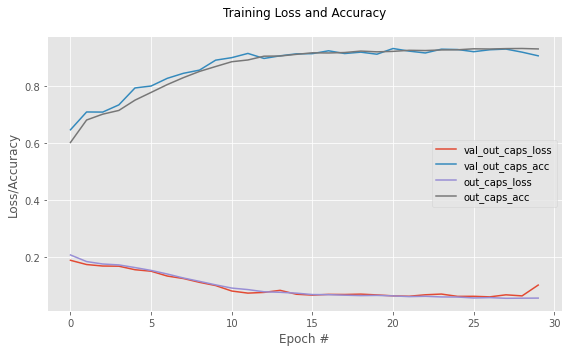


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.101    | 0.901    | 0.868     | 0.944    | 0.905   

Best model (min val loss) scores

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.061    | 0.924    | 0.906     | 0.946    | 0.926   

-------------------------------
Testing with filter sizes [4, 8]
Testing with kernel sizes [5, 9]
-------------------------------
Train on 22321 samples, validate on 2481 samples
Epoch 1/30
22321/22321 [==============================] - 21s 929us/step - loss: 0.2014 - out_caps_loss: 0.2014 - out_recon_loss: 0.0738 - out_caps_acc: 0.6185 - out_recon_acc: 0.4296 - val_loss: 0.1853 - val_out_caps_loss: 0.1853 - val_out_recon_loss: 0.0354 - val_out_caps_acc: 0.6840 - val_out_recon_acc: 0.5402
Epoch 2/30
22321/22321 [==============================] - 20s 879us/s

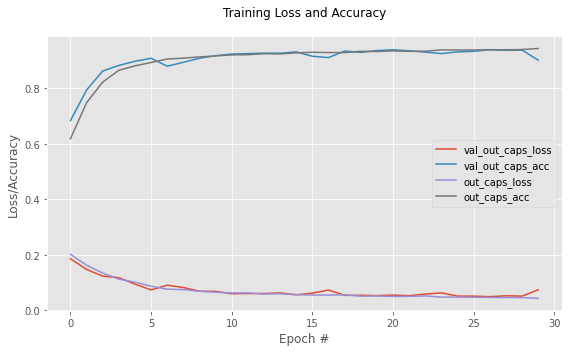


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.071    | 0.900    | 0.855     | 0.964    | 0.906   

Best model (min val loss) scores

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.048    | 0.938    | 0.958     | 0.916    | 0.937   

-------------------------------
Testing with filter sizes [4, 8]
Testing with kernel sizes [5, 9]
-------------------------------
Train on 22321 samples, validate on 2481 samples
Epoch 1/30
22321/22321 [==============================] - 21s 932us/step - loss: 0.2009 - out_caps_loss: 0.2009 - out_recon_loss: 0.0737 - out_caps_acc: 0.6126 - out_recon_acc: 0.4317 - val_loss: 0.1764 - val_out_caps_loss: 0.1764 - val_out_recon_loss: 0.0355 - val_out_caps_acc: 0.7134 - val_out_recon_acc: 0.5411
Epoch 2/30
22321/22321 [==============================] - 20s 914us/s

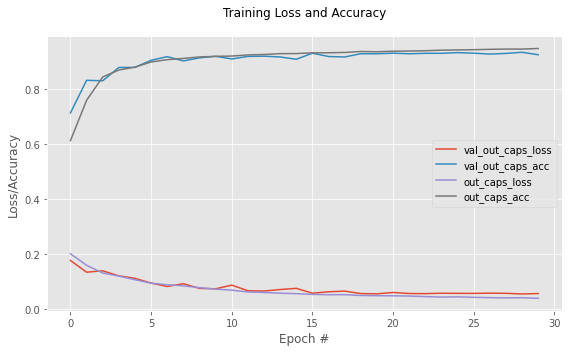


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.055    | 0.930    | 0.913     | 0.950    | 0.931   

Best model (min val loss) scores

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.055    | 0.932    | 0.956     | 0.905    | 0.930   

-------------------------------
Testing with filter sizes [4, 8]
Testing with kernel sizes [5, 9]
-------------------------------
Train on 22321 samples, validate on 2481 samples
Epoch 1/30
22321/22321 [==============================] - 22s 994us/step - loss: 0.1944 - out_caps_loss: 0.1944 - out_recon_loss: 0.0740 - out_caps_acc: 0.6372 - out_recon_acc: 0.4301 - val_loss: 0.1695 - val_out_caps_loss: 0.1695 - val_out_recon_loss: 0.0355 - val_out_caps_acc: 0.7630 - val_out_recon_acc: 0.5429
Epoch 2/30
22321/22321 [==============================] - 20s 902us/s

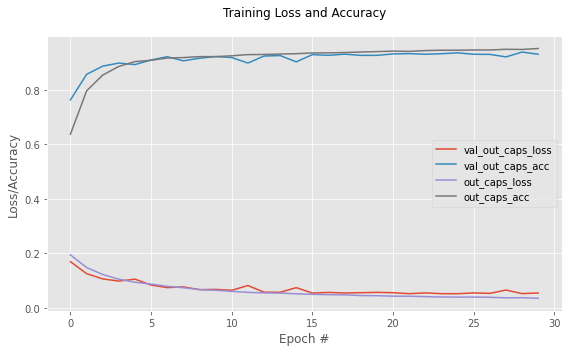


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.051    | 0.937    | 0.927     | 0.948    | 0.937   

Best model (min val loss) scores

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.049    | 0.940    | 0.948     | 0.932    | 0.940   

-------------------------------
Testing with filter sizes [4, 8]
Testing with kernel sizes [5, 9]
-------------------------------
Train on 22321 samples, validate on 2481 samples
Epoch 1/30
22321/22321 [==============================] - 22s 1ms/step - loss: 0.1975 - out_caps_loss: 0.1975 - out_recon_loss: 0.0743 - out_caps_acc: 0.6300 - out_recon_acc: 0.4283 - val_loss: 0.1651 - val_out_caps_loss: 0.1651 - val_out_recon_loss: 0.0354 - val_out_caps_acc: 0.7598 - val_out_recon_acc: 0.5432
Epoch 2/30
22321/22321 [==============================] - 21s 923us/ste

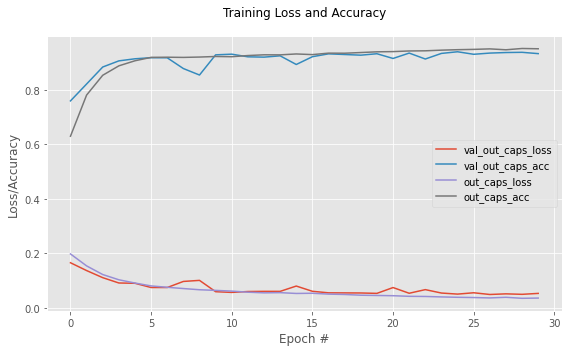


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.050    | 0.935    | 0.927     | 0.944    | 0.935   

Best model (min val loss) scores

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.047    | 0.942    | 0.952     | 0.931    | 0.941   



In [0]:
f_size=[4,8]
k_size=[5,9]
d_dims = [1,2,4,8,16]
frac = 100
for d_dim in d_dims:
    print("-------------------------------")
    print("Testing with filter sizes {}".format(f_size))
    print("Testing with kernel sizes {}".format(k_size))
    print("-------------------------------")
    (model, scores), hist = CapsTest(k_size, 
                                    frac=frac, 
                                    bs=BATCH_SIZE, 
                                    epochs=EPOCHS//2, 
                                    plot = True, 
                                    f_sizes=f_size,
                                    es=False,
                                    mshow=False,
                                    d_dim=d_dim,
                                    p_dim=8,
                                    bestFile="test_{}.h5".format(k_size),
                                    pltFile="7_CapsnetColor_k{}.f{}.d{}.png".format(k_size, f_size, d_dim))
    showScores(scores)

    print("")
    print("Best model (min val loss) scores")
    model.load_weights("test_{}.h5".format(k_size))
    showModelScores(model, test_X, test_Y)
    print("") 

-------------------------------
Testing with filter sizes [8, 16]
Testing with kernel sizes [5, 9]
-------------------------------
Train on 22321 samples, validate on 2481 samples
Epoch 1/30
22321/22321 [==============================] - 25s 1ms/step - loss: 0.2119 - out_caps_loss: 0.2119 - out_recon_loss: 0.0708 - out_caps_acc: 0.5775 - out_recon_acc: 0.4384 - val_loss: 0.2089 - val_out_caps_loss: 0.2089 - val_out_recon_loss: 0.0352 - val_out_caps_acc: 0.6203 - val_out_recon_acc: 0.5388
Epoch 2/30
22321/22321 [==============================] - 22s 1ms/step - loss: 0.1849 - out_caps_loss: 0.1849 - out_recon_loss: 0.0346 - out_caps_acc: 0.6773 - out_recon_acc: 0.5270 - val_loss: 0.2095 - val_out_caps_loss: 0.2094 - val_out_recon_loss: 0.0349 - val_out_caps_acc: 0.6969 - val_out_recon_acc: 0.5199
Epoch 3/30
22321/22321 [==============================] - 23s 1ms/step - loss: 0.1750 - out_caps_loss: 0.1750 - out_recon_loss: 0.0345 - out_caps_acc: 0.6994 - out_recon_acc: 0.5144 - val_loss: 

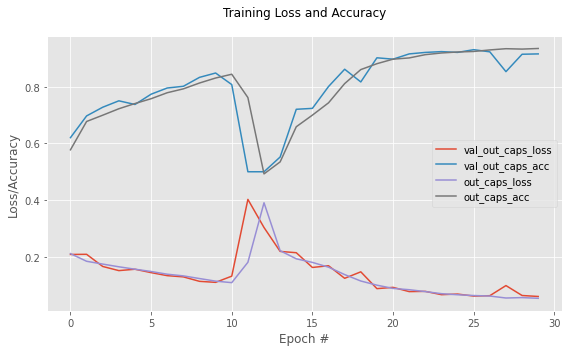


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.064    | 0.918    | 0.889     | 0.956    | 0.921   

Best model (min val loss) scores

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.064    | 0.918    | 0.889     | 0.956    | 0.921   

-------------------------------
Testing with filter sizes [8, 16]
Testing with kernel sizes [5, 9]
-------------------------------
Train on 22321 samples, validate on 2481 samples
Epoch 1/30
22321/22321 [==============================] - 25s 1ms/step - loss: 0.2078 - out_caps_loss: 0.2078 - out_recon_loss: 0.0726 - out_caps_acc: 0.6008 - out_recon_acc: 0.4307 - val_loss: 0.1808 - val_out_caps_loss: 0.1807 - val_out_recon_loss: 0.0354 - val_out_caps_acc: 0.6904 - val_out_recon_acc: 0.5380
Epoch 2/30
22321/22321 [==============================] - 22s 981us/st

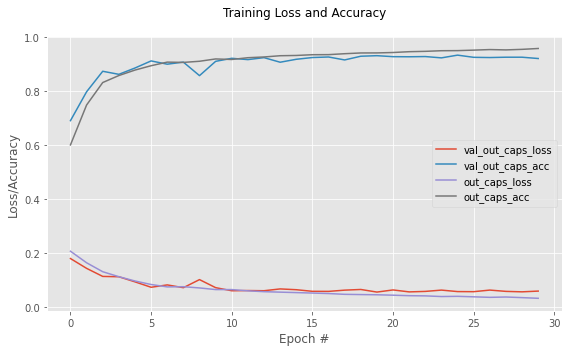


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.061    | 0.923    | 0.905     | 0.944    | 0.924   

Best model (min val loss) scores

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.056    | 0.927    | 0.936     | 0.918    | 0.927   

-------------------------------
Testing with filter sizes [8, 16]
Testing with kernel sizes [5, 9]
-------------------------------
Train on 22321 samples, validate on 2481 samples
Epoch 1/30
22321/22321 [==============================] - 25s 1ms/step - loss: 0.2069 - out_caps_loss: 0.2068 - out_recon_loss: 0.0738 - out_caps_acc: 0.5965 - out_recon_acc: 0.4236 - val_loss: 0.1902 - val_out_caps_loss: 0.1902 - val_out_recon_loss: 0.0355 - val_out_caps_acc: 0.6655 - val_out_recon_acc: 0.5388
Epoch 2/30
22321/22321 [==============================] - 22s 978us/st

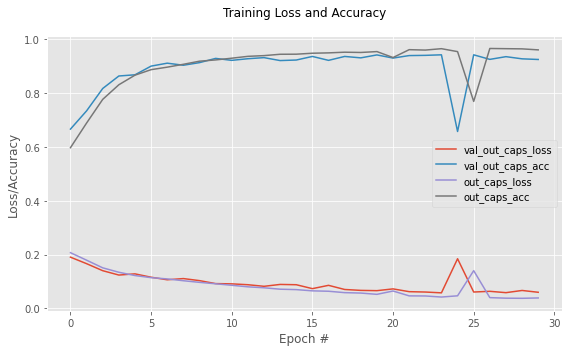


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.057    | 0.931    | 0.943     | 0.918    | 0.930   

Best model (min val loss) scores

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.058    | 0.942    | 0.946     | 0.936    | 0.941   

-------------------------------
Testing with filter sizes [8, 16]
Testing with kernel sizes [5, 9]
-------------------------------
Train on 22321 samples, validate on 2481 samples
Epoch 1/30
22321/22321 [==============================] - 26s 1ms/step - loss: 0.2033 - out_caps_loss: 0.2032 - out_recon_loss: 0.0757 - out_caps_acc: 0.6145 - out_recon_acc: 0.4258 - val_loss: 0.1750 - val_out_caps_loss: 0.1749 - val_out_recon_loss: 0.0355 - val_out_caps_acc: 0.6993 - val_out_recon_acc: 0.5422
Epoch 2/30
22321/22321 [==============================] - 23s 1ms/step

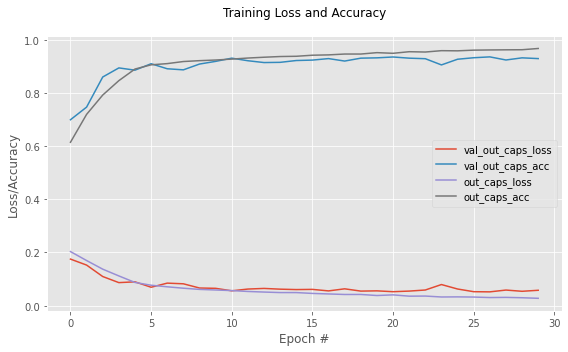


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.057    | 0.929    | 0.905     | 0.959    | 0.931   

Best model (min val loss) scores

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.052    | 0.934    | 0.940     | 0.927    | 0.933   

-------------------------------
Testing with filter sizes [8, 16]
Testing with kernel sizes [5, 9]
-------------------------------
Train on 22321 samples, validate on 2481 samples
Epoch 1/30
22321/22321 [==============================] - 25s 1ms/step - loss: 0.2002 - out_caps_loss: 0.2002 - out_recon_loss: 0.0762 - out_caps_acc: 0.6265 - out_recon_acc: 0.4265 - val_loss: 0.1819 - val_out_caps_loss: 0.1819 - val_out_recon_loss: 0.0357 - val_out_caps_acc: 0.6896 - val_out_recon_acc: 0.5452
Epoch 2/30
22321/22321 [==============================] - 22s 975us/st

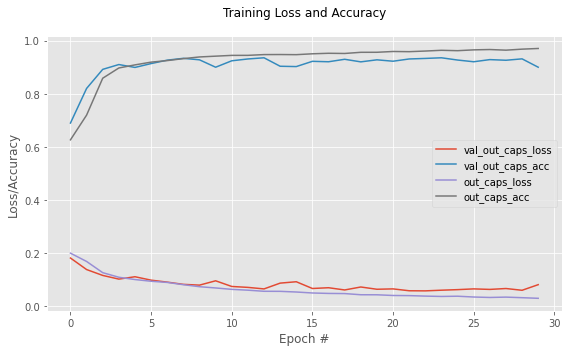


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.082    | 0.905    | 0.860     | 0.966    | 0.910   

Best model (min val loss) scores

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.055    | 0.939    | 0.949     | 0.927    | 0.938   



In [0]:
f_size=[8, 16]
k_size=[5,9]
d_dims = [1,2,4,8,16]
frac = 100
for d_dim in d_dims:
    print("-------------------------------")
    print("Testing with filter sizes {}".format(f_size))
    print("Testing with kernel sizes {}".format(k_size))
    print("-------------------------------")
    (model, scores), hist = CapsTest(k_size, 
                                    frac=frac, 
                                    bs=BATCH_SIZE, 
                                    epochs=EPOCHS//2, 
                                    plot = True, 
                                    f_sizes=f_size,
                                    es=False,
                                    mshow=False,
                                    d_dim=d_dim,
                                    p_dim=8,
                                    bestFile="test_{}.h5".format(k_size),
                                    pltFile="7_CapsnetColor_k{}.f{}.d{}.png".format(k_size, f_size, d_dim))
    showScores(scores)

    print("")
    print("Best model (min val loss) scores")
    model.load_weights("test_{}.h5".format(k_size))
    showModelScores(model, test_X, test_Y)
    print("") 

#9. Test with Sc set to 1.

-------------------------------
Testing with kernel sizes 5/7
-------------------------------
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 44, 44, 3)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 40, 40, 4)    304         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 34, 34, 8)    1576        conv1[0][0]                      
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 1156, 8)      0           conv2d_1[0][0]                   
_______________

Epoch 17/30
22321/22321 [==============================] - 25s 1ms/step - loss: nan - out_caps_loss: 0.0000e+00 - out_recon_loss: nan - out_caps_acc: 0.5000 - out_recon_acc: 0.4938 - val_loss: nan - val_out_caps_loss: 0.0000e+00 - val_out_recon_loss: nan - val_out_caps_acc: 0.4998 - val_out_recon_acc: 0.4975
Epoch 18/30
22321/22321 [==============================] - 25s 1ms/step - loss: nan - out_caps_loss: 0.0000e+00 - out_recon_loss: nan - out_caps_acc: 0.5000 - out_recon_acc: 0.4938 - val_loss: nan - val_out_caps_loss: 0.0000e+00 - val_out_recon_loss: nan - val_out_caps_acc: 0.4998 - val_out_recon_acc: 0.4975
Epoch 19/30
22321/22321 [==============================] - 25s 1ms/step - loss: nan - out_caps_loss: 0.0000e+00 - out_recon_loss: nan - out_caps_acc: 0.5000 - out_recon_acc: 0.4938 - val_loss: nan - val_out_caps_loss: 0.0000e+00 - val_out_recon_loss: nan - val_out_caps_acc: 0.4998 - val_out_recon_acc: 0.4975
Epoch 20/30
22321/22321 [==============================] - 25s 1ms/ste

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Plotting Model accuracy and loss versus epoch


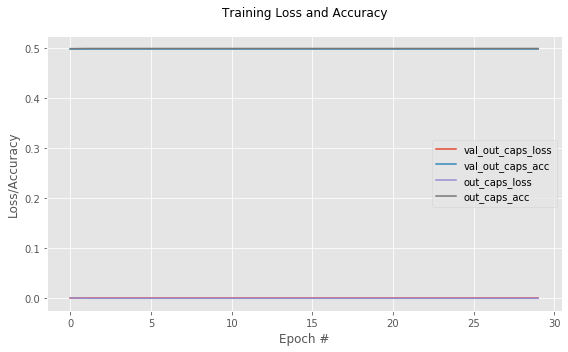

Model scores at end of training

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| nan      | 0.500    | 0.000     | 0.000    | 0.000   

Best model (min val loss) scores


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| nan      | 0.500    | 0.000     | 0.000    | 0.000   

-------------------------------
Testing with kernel sizes 5/9
-------------------------------
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 44, 44, 3)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 40, 40, 4)    304         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 8)    2600        conv1[0][0]                      
___________

22321/22321 [==============================] - 26s 1ms/step - loss: nan - out_caps_loss: 0.0000e+00 - out_recon_loss: nan - out_caps_acc: 0.5000 - out_recon_acc: 0.4938 - val_loss: nan - val_out_caps_loss: 0.0000e+00 - val_out_recon_loss: nan - val_out_caps_acc: 0.4998 - val_out_recon_acc: 0.4975
Epoch 17/30
22321/22321 [==============================] - 25s 1ms/step - loss: nan - out_caps_loss: 0.0000e+00 - out_recon_loss: nan - out_caps_acc: 0.5000 - out_recon_acc: 0.4938 - val_loss: nan - val_out_caps_loss: 0.0000e+00 - val_out_recon_loss: nan - val_out_caps_acc: 0.4998 - val_out_recon_acc: 0.4975
Epoch 18/30
22321/22321 [==============================] - 26s 1ms/step - loss: nan - out_caps_loss: 0.0000e+00 - out_recon_loss: nan - out_caps_acc: 0.5000 - out_recon_acc: 0.4938 - val_loss: nan - val_out_caps_loss: 0.0000e+00 - val_out_recon_loss: nan - val_out_caps_acc: 0.4998 - val_out_recon_acc: 0.4975
Epoch 19/30
22321/22321 [==============================] - 25s 1ms/step - loss: na

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Plotting Model accuracy and loss versus epoch


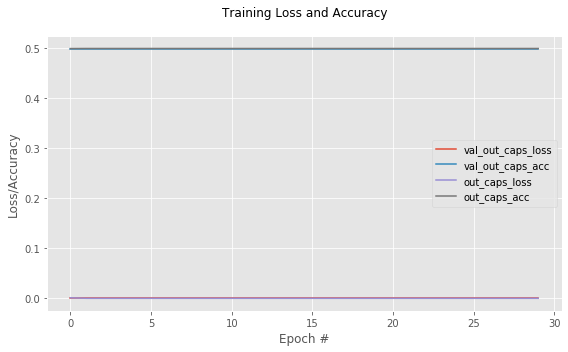

Model scores at end of training

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| nan      | 0.500    | 0.000     | 0.000    | 0.000   

Best model (min val loss) scores

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| nan      | 0.500    | 0.000     | 0.000    | 0.000   



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
kernels = [[5,7], 
           [5,9]]

f_size=[4,8]
frac = 100

for k_size in kernels:
    print("-------------------------------")
    print("Testing with kernel sizes {}/{}".format(k_size[0],k_size[1]))
    print("-------------------------------")
    (model, scores), hist = CapsTest(k_size, 
                                    frac=frac, 
                                    bs=BATCH_SIZE, 
                                    epochs=EPOCHS//2, 
                                    plot=True, 
                                    mshow=True,
                                    es=False,
                                    sc=1,
                                    f_sizes=f_size,
                                    bestFile="7_CapsnetModel_test.h5",
                                    pltFile="7_CapsnetModel_{}_{}_frac{}.png".format(k_size, 
                                                                                     f_size,
                                                                                     frac))
    print("Model scores at end of training")
    showScores(scores)
    print("")
    print("Best model (min val loss) scores")
    try:
        model.load_weights("7_CapsnetModel_test.h5")
        showModelScores(model, test_X, test_Y)
    except:
        pass
    print("")  

-------------------------------
Testing with kernel sizes 7/9
-------------------------------
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 44, 44, 3)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 38, 38, 4)    592         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 30, 30, 8)    2600        conv1[0][0]                      
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 900, 8)       0           conv2d_1[0][0]                   
_______________

Epoch 17/30
22321/22321 [==============================] - 25s 1ms/step - loss: nan - out_caps_loss: 0.0000e+00 - out_recon_loss: nan - out_caps_acc: 0.5000 - out_recon_acc: 0.4938 - val_loss: nan - val_out_caps_loss: 0.0000e+00 - val_out_recon_loss: nan - val_out_caps_acc: 0.4998 - val_out_recon_acc: 0.4975
Epoch 18/30
22321/22321 [==============================] - 25s 1ms/step - loss: nan - out_caps_loss: 0.0000e+00 - out_recon_loss: nan - out_caps_acc: 0.5000 - out_recon_acc: 0.4938 - val_loss: nan - val_out_caps_loss: 0.0000e+00 - val_out_recon_loss: nan - val_out_caps_acc: 0.4998 - val_out_recon_acc: 0.4975
Epoch 19/30
22321/22321 [==============================] - 25s 1ms/step - loss: nan - out_caps_loss: 0.0000e+00 - out_recon_loss: nan - out_caps_acc: 0.5000 - out_recon_acc: 0.4938 - val_loss: nan - val_out_caps_loss: 0.0000e+00 - val_out_recon_loss: nan - val_out_caps_acc: 0.4998 - val_out_recon_acc: 0.4975
Epoch 20/30
22321/22321 [==============================] - 25s 1ms/ste

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Plotting Model accuracy and loss versus epoch


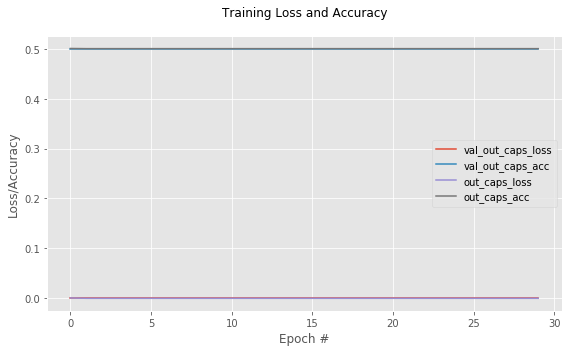

Model scores at end of training

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| nan      | 0.500    | 0.000     | 0.000    | 0.000   

Best model (min val loss) scores


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| nan      | 0.500    | 0.000     | 0.000    | 0.000   

-------------------------------
Testing with kernel sizes 9/9
-------------------------------
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 44, 44, 3)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 36, 36, 4)    976         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 8)    2600        conv1[0][0]                      
___________

22321/22321 [==============================] - 26s 1ms/step - loss: 0.0699 - out_caps_loss: 0.0699 - out_recon_loss: 0.0336 - out_caps_acc: 0.9455 - out_recon_acc: 0.5105 - val_loss: 0.0849 - val_out_caps_loss: 0.0849 - val_out_recon_loss: 0.0341 - val_out_caps_acc: 0.9133 - val_out_recon_acc: 0.5069
Epoch 17/30
22321/22321 [==============================] - 26s 1ms/step - loss: 0.0683 - out_caps_loss: 0.0683 - out_recon_loss: 0.0336 - out_caps_acc: 0.9461 - out_recon_acc: 0.5103 - val_loss: 0.0830 - val_out_caps_loss: 0.0830 - val_out_recon_loss: 0.0343 - val_out_caps_acc: 0.9162 - val_out_recon_acc: 0.5067
Epoch 18/30
22321/22321 [==============================] - 26s 1ms/step - loss: 0.0666 - out_caps_loss: 0.0666 - out_recon_loss: 0.0336 - out_caps_acc: 0.9478 - out_recon_acc: 0.5103 - val_loss: 0.0788 - val_out_caps_loss: 0.0788 - val_out_recon_loss: 0.0343 - val_out_caps_acc: 0.9270 - val_out_recon_acc: 0.5065
Epoch 19/30
22321/22321 [==============================] - 26s 1ms/ste

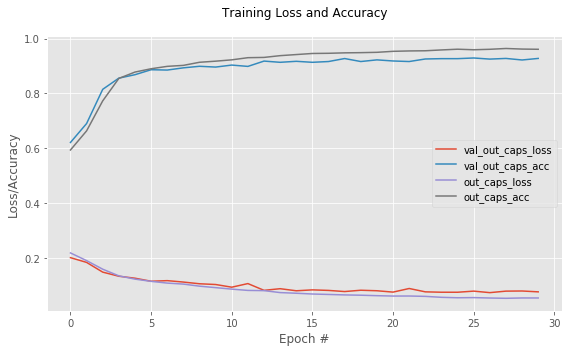

Model scores at end of training

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.078    | 0.930    | 0.916     | 0.946    | 0.931   

Best model (min val loss) scores

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.076    | 0.931    | 0.925     | 0.937    | 0.931   



In [0]:
kernels = [[7,9], 
           [9,9]]

f_size=[4,8]
frac = 100

for k_size in kernels:
    print("-------------------------------")
    print("Testing with kernel sizes {}/{}".format(k_size[0],k_size[1]))
    print("-------------------------------")
    (model, scores), hist = CapsTest(k_size, 
                                    frac=frac, 
                                    bs=BATCH_SIZE, 
                                    epochs=EPOCHS//2, 
                                    plot=True, 
                                    mshow=True,
                                    es=False,
                                    sc=1,
                                    f_sizes=f_size,
                                    bestFile="7_CapsnetModel_test.h5",
                                    pltFile="7_CapsnetModel_{}_{}_frac{}.png".format(k_size, 
                                                                                     f_size,
                                                                                     frac))
    print("Model scores at end of training")
    showScores(scores)
    print("")
    print("Best model (min val loss) scores")
    try:
        model.load_weights("7_CapsnetModel_test.h5")
        showModelScores(model, test_X, test_Y)
    except:
        pass
    print("")  

-------------------------------
Testing with kernel sizes 5/11
-------------------------------
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 44, 44, 3)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 40, 40, 4)    304         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 30, 30, 8)    3880        conv1[0][0]                      
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 900, 8)       0           conv2d_1[0][0]                   
______________

Epoch 17/30
22321/22321 [==============================] - 26s 1ms/step - loss: 0.0550 - out_caps_loss: 0.0550 - out_recon_loss: 0.0339 - out_caps_acc: 0.9391 - out_recon_acc: 0.5084 - val_loss: 0.0592 - val_out_caps_loss: 0.0592 - val_out_recon_loss: 0.0346 - val_out_caps_acc: 0.9412 - val_out_recon_acc: 0.5044
Epoch 18/30
22321/22321 [==============================] - 26s 1ms/step - loss: 0.0504 - out_caps_loss: 0.0504 - out_recon_loss: 0.0339 - out_caps_acc: 0.9424 - out_recon_acc: 0.5083 - val_loss: 0.0685 - val_out_caps_loss: 0.0685 - val_out_recon_loss: 0.0346 - val_out_caps_acc: 0.9206 - val_out_recon_acc: 0.5049
Epoch 19/30
22321/22321 [==============================] - 26s 1ms/step - loss: 0.0496 - out_caps_loss: 0.0496 - out_recon_loss: 0.0339 - out_caps_acc: 0.9423 - out_recon_acc: 0.5081 - val_loss: 0.0662 - val_out_caps_loss: 0.0662 - val_out_recon_loss: 0.0346 - val_out_caps_acc: 0.9202 - val_out_recon_acc: 0.5045
Epoch 20/30
22321/22321 [==============================] -

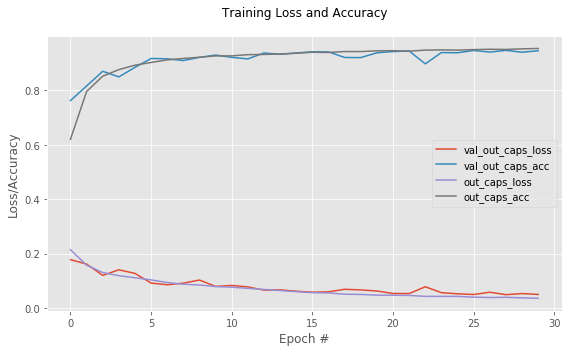

Model scores at end of training

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.050    | 0.945    | 0.957     | 0.933    | 0.945   

Best model (min val loss) scores

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.049    | 0.947    | 0.958     | 0.935    | 0.947   

-------------------------------
Testing with kernel sizes 5/13
-------------------------------
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 44, 44, 3)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 4

22321/22321 [==============================] - 27s 1ms/step - loss: 0.0611 - out_caps_loss: 0.0611 - out_recon_loss: 0.0339 - out_caps_acc: 0.9471 - out_recon_acc: 0.5115 - val_loss: 0.0732 - val_out_caps_loss: 0.0731 - val_out_recon_loss: 0.0346 - val_out_caps_acc: 0.9343 - val_out_recon_acc: 0.5073
Epoch 16/30
22321/22321 [==============================] - 27s 1ms/step - loss: 0.0615 - out_caps_loss: 0.0615 - out_recon_loss: 0.0339 - out_caps_acc: 0.9462 - out_recon_acc: 0.5111 - val_loss: 0.0725 - val_out_caps_loss: 0.0725 - val_out_recon_loss: 0.0345 - val_out_caps_acc: 0.9279 - val_out_recon_acc: 0.5073
Epoch 17/30
22321/22321 [==============================] - 27s 1ms/step - loss: 0.0577 - out_caps_loss: 0.0577 - out_recon_loss: 0.0339 - out_caps_acc: 0.9489 - out_recon_acc: 0.5109 - val_loss: 0.0701 - val_out_caps_loss: 0.0700 - val_out_recon_loss: 0.0346 - val_out_caps_acc: 0.9339 - val_out_recon_acc: 0.5074
Epoch 18/30
22321/22321 [==============================] - 27s 1ms/ste

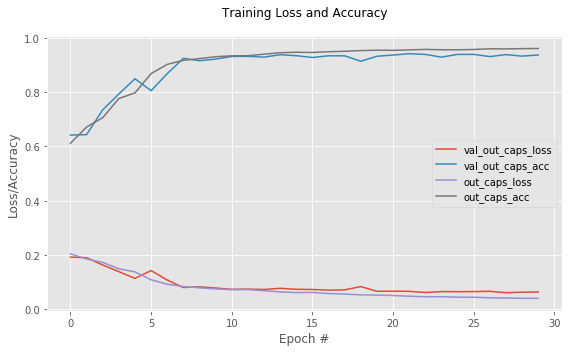

Model scores at end of training

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.063    | 0.935    | 0.959     | 0.909    | 0.934   

Best model (min val loss) scores

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.060    | 0.939    | 0.952     | 0.926    | 0.939   



In [0]:
kernels = [[5,11],
           [5,13]]

f_size=[4,8]
frac = 100

for k_size in kernels:
    print("-------------------------------")
    print("Testing with kernel sizes {}/{}".format(k_size[0],k_size[1]))
    print("-------------------------------")
    (model, scores), hist = CapsTest(k_size, 
                                    frac=frac, 
                                    bs=BATCH_SIZE, 
                                    epochs=EPOCHS//2, 
                                    plot=True, 
                                    mshow=True,
                                    sc=1,
                                    es=False,
                                    f_sizes=f_size,
                                    bestFile="7_CapsnetModel_test.h5",
                                    pltFile="7_CapsnetModel_{}_{}_frac{}.png".format(k_size, 
                                                                                     f_size,
                                                                                     frac))
    print("Model scores at end of training")
    showScores(scores)
    print("")
    print("Best model (min val loss) scores")
    try:
        model.load_weights("7_CapsnetModel_test.h5")
        showModelScores(model, test_X, test_Y)
    except:
        pass
    print("")  

-------------------------------
Testing with kernel sizes 7/11
-------------------------------
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 44, 44, 3)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 38, 38, 4)    592         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 8)    3880        conv1[0][0]                      
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 784, 8)       0           conv2d_1[0][0]                   
______________

Epoch 17/30
22321/22321 [==============================] - 26s 1ms/step - loss: 0.0683 - out_caps_loss: 0.0683 - out_recon_loss: 0.0337 - out_caps_acc: 0.9437 - out_recon_acc: 0.5110 - val_loss: 0.0816 - val_out_caps_loss: 0.0816 - val_out_recon_loss: 0.0343 - val_out_caps_acc: 0.9146 - val_out_recon_acc: 0.5074
Epoch 18/30
22321/22321 [==============================] - 26s 1ms/step - loss: 0.0675 - out_caps_loss: 0.0675 - out_recon_loss: 0.0337 - out_caps_acc: 0.9455 - out_recon_acc: 0.5108 - val_loss: 0.0832 - val_out_caps_loss: 0.0831 - val_out_recon_loss: 0.0343 - val_out_caps_acc: 0.9105 - val_out_recon_acc: 0.5073
Epoch 19/30
22321/22321 [==============================] - 26s 1ms/step - loss: 0.0658 - out_caps_loss: 0.0657 - out_recon_loss: 0.0337 - out_caps_acc: 0.9471 - out_recon_acc: 0.5106 - val_loss: 0.0820 - val_out_caps_loss: 0.0820 - val_out_recon_loss: 0.0343 - val_out_caps_acc: 0.9158 - val_out_recon_acc: 0.5070
Epoch 20/30
22321/22321 [==============================] -

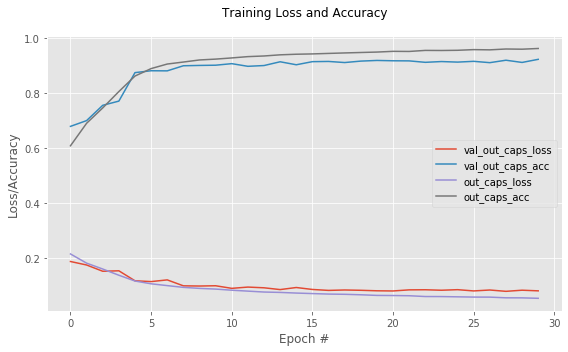

Model scores at end of training

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.078    | 0.921    | 0.928     | 0.914    | 0.921   

Best model (min val loss) scores

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.075    | 0.922    | 0.925     | 0.918    | 0.921   

-------------------------------
Testing with kernel sizes 7/13
-------------------------------
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 44, 44, 3)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 3

22321/22321 [==============================] - 26s 1ms/step - loss: 0.0693 - out_caps_loss: 0.0693 - out_recon_loss: 0.0337 - out_caps_acc: 0.9441 - out_recon_acc: 0.5109 - val_loss: 0.0770 - val_out_caps_loss: 0.0770 - val_out_recon_loss: 0.0345 - val_out_caps_acc: 0.9303 - val_out_recon_acc: 0.5077
Epoch 16/30
22321/22321 [==============================] - 26s 1ms/step - loss: 0.0679 - out_caps_loss: 0.0679 - out_recon_loss: 0.0337 - out_caps_acc: 0.9477 - out_recon_acc: 0.5106 - val_loss: 0.0830 - val_out_caps_loss: 0.0830 - val_out_recon_loss: 0.0345 - val_out_caps_acc: 0.9311 - val_out_recon_acc: 0.5071
Epoch 17/30
22321/22321 [==============================] - 26s 1ms/step - loss: 0.0668 - out_caps_loss: 0.0668 - out_recon_loss: 0.0337 - out_caps_acc: 0.9492 - out_recon_acc: 0.5104 - val_loss: 0.0727 - val_out_caps_loss: 0.0727 - val_out_recon_loss: 0.0345 - val_out_caps_acc: 0.9323 - val_out_recon_acc: 0.5069
Epoch 18/30
22321/22321 [==============================] - 26s 1ms/ste

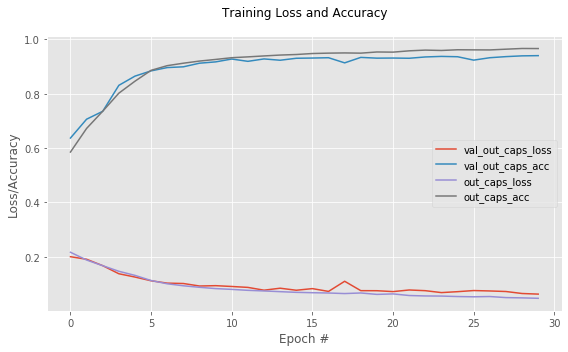

Model scores at end of training

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.067    | 0.933    | 0.933     | 0.933    | 0.933   

Best model (min val loss) scores

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.067    | 0.933    | 0.933     | 0.933    | 0.933   



In [0]:
kernels = [[7,11],
           [7,13]]

f_size=[4,8]
frac = 100

for k_size in kernels:
    print("-------------------------------")
    print("Testing with kernel sizes {}/{}".format(k_size[0],k_size[1]))
    print("-------------------------------")
    (model, scores), hist = CapsTest(k_size, 
                                    frac=frac, 
                                    bs=BATCH_SIZE, 
                                    epochs=EPOCHS//2, 
                                    plot=True, 
                                    mshow=True,
                                    sc=1,
                                    es=False,
                                    f_sizes=f_size,
                                    bestFile="7_CapsnetModel_test.h5",
                                    pltFile="7_CapsnetModel_{}_{}_frac{}.png".format(k_size, 
                                                                                     f_size,
                                                                                     frac))
    print("Model scores at end of training")
    showScores(scores)
    print("")
    print("Best model (min val loss) scores")
    try:
        model.load_weights("7_CapsnetModel_test.h5")
        showModelScores(model, test_X, test_Y)
    except:
        pass
    print("")  

-------------------------------
Testing with kernel sizes 9/11
-------------------------------
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 44, 44, 3)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 36, 36, 4)    976         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 26, 26, 8)    3880        conv1[0][0]                      
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 676, 8)       0           conv2d_1[0][0]                   
______________

Epoch 17/30
22321/22321 [==============================] - 26s 1ms/step - loss: 0.0741 - out_caps_loss: 0.0740 - out_recon_loss: 0.0334 - out_caps_acc: 0.9376 - out_recon_acc: 0.5105 - val_loss: 0.0905 - val_out_caps_loss: 0.0905 - val_out_recon_loss: 0.0340 - val_out_caps_acc: 0.9101 - val_out_recon_acc: 0.5071
Epoch 18/30
22321/22321 [==============================] - 26s 1ms/step - loss: 0.0733 - out_caps_loss: 0.0733 - out_recon_loss: 0.0333 - out_caps_acc: 0.9395 - out_recon_acc: 0.5103 - val_loss: 0.0961 - val_out_caps_loss: 0.0961 - val_out_recon_loss: 0.0337 - val_out_caps_acc: 0.8956 - val_out_recon_acc: 0.5062
Epoch 19/30
22321/22321 [==============================] - 26s 1ms/step - loss: 0.0702 - out_caps_loss: 0.0702 - out_recon_loss: 0.0332 - out_caps_acc: 0.9433 - out_recon_acc: 0.5103 - val_loss: 0.0881 - val_out_caps_loss: 0.0881 - val_out_recon_loss: 0.0335 - val_out_caps_acc: 0.9089 - val_out_recon_acc: 0.5068
Epoch 20/30
22321/22321 [==============================] -

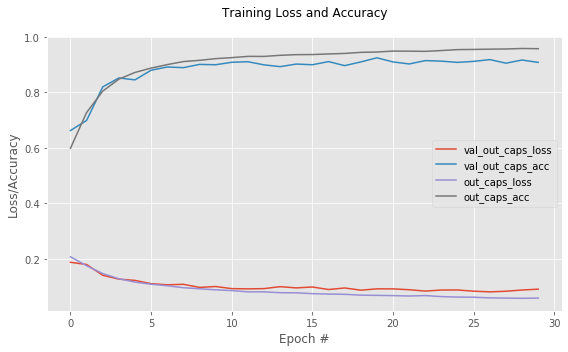

Model scores at end of training

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.092    | 0.902    | 0.910     | 0.893    | 0.901   

Best model (min val loss) scores

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.083    | 0.915    | 0.923     | 0.906    | 0.914   



In [0]:
kernels = [[9,11]]

f_size=[4,8]
frac = 100

for k_size in kernels:
    print("-------------------------------")
    print("Testing with kernel sizes {}/{}".format(k_size[0],k_size[1]))
    print("-------------------------------")
    (model, scores), hist = CapsTest(k_size, 
                                    frac=frac, 
                                    bs=BATCH_SIZE, 
                                    epochs=EPOCHS//2, 
                                    plot=True, 
                                    mshow=True,
                                    sc=1,
                                    es=False,
                                    f_sizes=f_size,
                                    bestFile="7_CapsnetModel_test.h5",
                                    pltFile="7_CapsnetModel_{}_{}_frac{}.png".format(k_size, 
                                                                                     f_size,
                                                                                     frac))
    print("Model scores at end of training")
    showScores(scores)
    print("")
    print("Best model (min val loss) scores")
    try:
        model.load_weights("7_CapsnetModel_test.h5")
        showModelScores(model, test_X, test_Y)
    except:
        pass
    print("")  

-------------------------------
Testing with kernel sizes 9/13
-------------------------------
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 44, 44, 3)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 36, 36, 4)    976         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 24, 24, 8)    5416        conv1[0][0]                      
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 576, 8)       0           conv2d_1[0][0]                   
______________

Epoch 17/30
22321/22321 [==============================] - 25s 1ms/step - loss: 0.0762 - out_caps_loss: 0.0762 - out_recon_loss: 0.0329 - out_caps_acc: 0.9339 - out_recon_acc: 0.5127 - val_loss: 0.0872 - val_out_caps_loss: 0.0871 - val_out_recon_loss: 0.0336 - val_out_caps_acc: 0.9178 - val_out_recon_acc: 0.5097
Epoch 18/30
22321/22321 [==============================] - 25s 1ms/step - loss: 0.0740 - out_caps_loss: 0.0740 - out_recon_loss: 0.0329 - out_caps_acc: 0.9366 - out_recon_acc: 0.5124 - val_loss: 0.0852 - val_out_caps_loss: 0.0852 - val_out_recon_loss: 0.0336 - val_out_caps_acc: 0.9210 - val_out_recon_acc: 0.5083
Epoch 19/30
22321/22321 [==============================] - 25s 1ms/step - loss: 0.0713 - out_caps_loss: 0.0713 - out_recon_loss: 0.0328 - out_caps_acc: 0.9397 - out_recon_acc: 0.5118 - val_loss: 0.0861 - val_out_caps_loss: 0.0861 - val_out_recon_loss: 0.0333 - val_out_caps_acc: 0.9017 - val_out_recon_acc: 0.5078
Epoch 20/30
22321/22321 [==============================] -

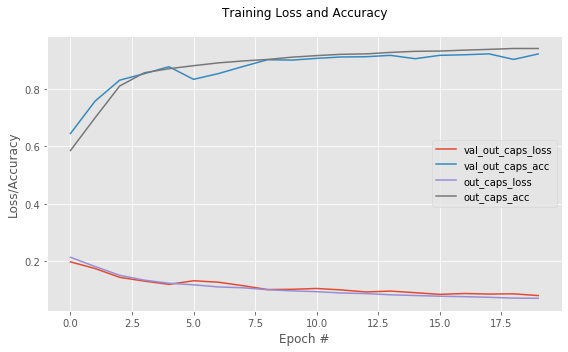

Model scores at end of training

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.076    | 0.929    | 0.912     | 0.951    | 0.931   

Best model (min val loss) scores

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.076    | 0.929    | 0.912     | 0.951    | 0.931   



In [0]:
kernels = [[9,13]]

f_size=[4,8]
frac = 100

for k_size in kernels:
    print("-------------------------------")
    print("Testing with kernel sizes {}/{}".format(k_size[0],k_size[1]))
    print("-------------------------------")
    (model, scores), hist = CapsTest(k_size, 
                                    frac=frac, 
                                    bs=BATCH_SIZE, 
                                    epochs=EPOCHS//2, 
                                    plot=True, 
                                    mshow=True,
                                    sc=1,
                                    es=True,
                                    f_sizes=f_size,
                                    bestFile="7_CapsnetModel_test.h5",
                                    pltFile="7_CapsnetModel_{}_{}_frac{}.png".format(k_size, 
                                                                                     f_size,
                                                                                     frac))
    print("Model scores at end of training")
    showScores(scores)
    print("")
    print("Best model (min val loss) scores")
    try:
        model.load_weights("7_CapsnetModel_test.h5")
        showModelScores(model, test_X, test_Y)
    except:
        pass
    print("")  

#10. Test with Sc set to 2.

-------------------------------
Testing with kernel sizes 5/7
-------------------------------
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 44, 44, 3)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 40, 40, 4)    304         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 17, 17, 8)    1576        conv1[0][0]                      
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 289, 8)       0           conv2d_1[0][0]                   
_______________

Epoch 17/30
22321/22321 [==============================] - 15s 682us/step - loss: nan - out_caps_loss: 0.0000e+00 - out_recon_loss: nan - out_caps_acc: 0.5000 - out_recon_acc: 0.4938 - val_loss: nan - val_out_caps_loss: 0.0000e+00 - val_out_recon_loss: nan - val_out_caps_acc: 0.4998 - val_out_recon_acc: 0.4975
Epoch 18/30
22321/22321 [==============================] - 15s 684us/step - loss: nan - out_caps_loss: 0.0000e+00 - out_recon_loss: nan - out_caps_acc: 0.5000 - out_recon_acc: 0.4938 - val_loss: nan - val_out_caps_loss: 0.0000e+00 - val_out_recon_loss: nan - val_out_caps_acc: 0.4998 - val_out_recon_acc: 0.4975
Epoch 19/30
22321/22321 [==============================] - 15s 685us/step - loss: nan - out_caps_loss: 0.0000e+00 - out_recon_loss: nan - out_caps_acc: 0.5000 - out_recon_acc: 0.4938 - val_loss: nan - val_out_caps_loss: 0.0000e+00 - val_out_recon_loss: nan - val_out_caps_acc: 0.4998 - val_out_recon_acc: 0.4975
Epoch 20/30
22321/22321 [==============================] - 15s 6

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Plotting Model accuracy and loss versus epoch


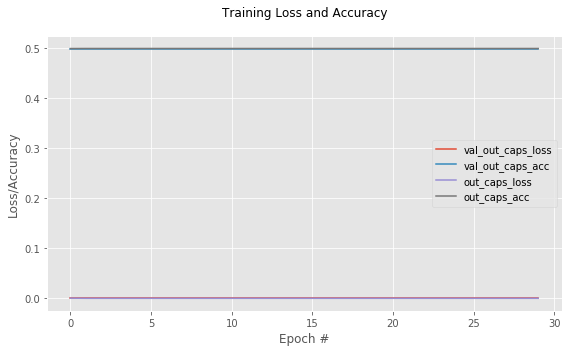

Model scores at end of training

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| nan      | 0.500    | 0.000     | 0.000    | 0.000   

Best model (min val loss) scores


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| nan      | 0.500    | 0.000     | 0.000    | 0.000   

-------------------------------
Testing with kernel sizes 5/9
-------------------------------
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 44, 44, 3)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 40, 40, 4)    304         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 8)    2600        conv1[0][0]                      
___________

Epoch 16/30
22321/22321 [==============================] - 15s 680us/step - loss: 0.0598 - out_caps_loss: 0.0598 - out_recon_loss: 0.0334 - out_caps_acc: 0.9254 - out_recon_acc: 0.5093 - val_loss: 0.0695 - val_out_caps_loss: 0.0694 - val_out_recon_loss: 0.0341 - val_out_caps_acc: 0.9226 - val_out_recon_acc: 0.5054
Epoch 17/30
22321/22321 [==============================] - 15s 679us/step - loss: 0.0558 - out_caps_loss: 0.0557 - out_recon_loss: 0.0333 - out_caps_acc: 0.9298 - out_recon_acc: 0.5089 - val_loss: 0.0714 - val_out_caps_loss: 0.0714 - val_out_recon_loss: 0.0339 - val_out_caps_acc: 0.9101 - val_out_recon_acc: 0.5057
Epoch 18/30
22321/22321 [==============================] - 15s 676us/step - loss: 0.0553 - out_caps_loss: 0.0553 - out_recon_loss: 0.0331 - out_caps_acc: 0.9295 - out_recon_acc: 0.5091 - val_loss: 0.0649 - val_out_caps_loss: 0.0648 - val_out_recon_loss: 0.0337 - val_out_caps_acc: 0.9190 - val_out_recon_acc: 0.5057
Epoch 19/30
22321/22321 [===========================

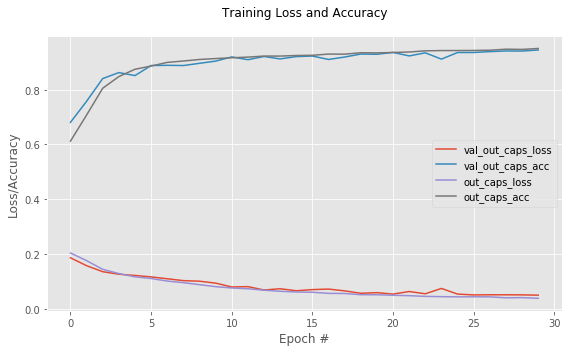

Model scores at end of training

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.051    | 0.941    | 0.953     | 0.927    | 0.940   

Best model (min val loss) scores

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.051    | 0.941    | 0.953     | 0.927    | 0.940   



In [0]:
kernels = [[5,7], 
           [5,9]]

f_size=[4,8]
frac = 100

for k_size in kernels:
    print("-------------------------------")
    print("Testing with kernel sizes {}/{}".format(k_size[0],k_size[1]))
    print("-------------------------------")
    (model, scores), hist = CapsTest(k_size, 
                                    frac=frac, 
                                    bs=BATCH_SIZE, 
                                    epochs=EPOCHS//2, 
                                    plot=True, 
                                    mshow=True,
                                    es=False,
                                    sc=2,
                                    f_sizes=f_size,
                                    bestFile="7_CapsnetModel_test.h5",
                                    pltFile="7_CapsnetModel_{}_{}_frac{}.png".format(k_size, 
                                                                                     f_size,
                                                                                     frac))
    print("Model scores at end of training")
    showScores(scores)
    print("")
    print("Best model (min val loss) scores")
    try:
        model.load_weights("7_CapsnetModel_test.h5")
        showModelScores(model, test_X, test_Y)
    except:
        pass
    print("")  

-------------------------------
Testing with kernel sizes 7/9
-------------------------------
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 44, 44, 3)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 38, 38, 4)    592         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 15, 15, 8)    2600        conv1[0][0]                      
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 225, 8)       0           conv2d_1[0][0]                   
_______________

22321/22321 [==============================] - 16s 710us/step - loss: 0.0751 - out_caps_loss: 0.0751 - out_recon_loss: 0.0335 - out_caps_acc: 0.9405 - out_recon_acc: 0.5121 - val_loss: 0.0876 - val_out_caps_loss: 0.0875 - val_out_recon_loss: 0.0341 - val_out_caps_acc: 0.9154 - val_out_recon_acc: 0.5088
Epoch 17/30
22321/22321 [==============================] - 16s 709us/step - loss: 0.0728 - out_caps_loss: 0.0727 - out_recon_loss: 0.0334 - out_caps_acc: 0.9414 - out_recon_acc: 0.5119 - val_loss: 0.0850 - val_out_caps_loss: 0.0850 - val_out_recon_loss: 0.0341 - val_out_caps_acc: 0.9206 - val_out_recon_acc: 0.5081
Epoch 18/30
22321/22321 [==============================] - 16s 717us/step - loss: 0.0725 - out_caps_loss: 0.0725 - out_recon_loss: 0.0334 - out_caps_acc: 0.9441 - out_recon_acc: 0.5118 - val_loss: 0.0853 - val_out_caps_loss: 0.0853 - val_out_recon_loss: 0.0340 - val_out_caps_acc: 0.9129 - val_out_recon_acc: 0.5078
Epoch 19/30
22321/22321 [==============================] - 16s 7

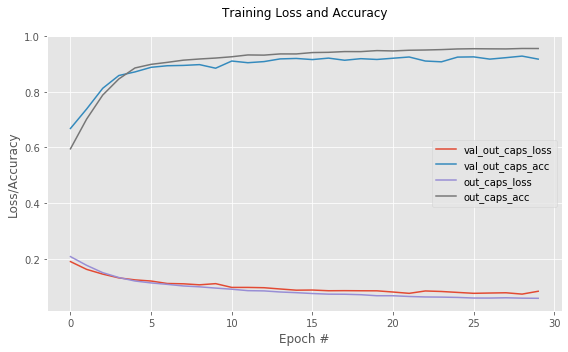

Model scores at end of training

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.081    | 0.927    | 0.916     | 0.940    | 0.928   

Best model (min val loss) scores

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.073    | 0.935    | 0.937     | 0.933    | 0.935   

-------------------------------
Testing with kernel sizes 9/9
-------------------------------
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 44, 44, 3)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 36

22321/22321 [==============================] - 17s 748us/step - loss: 0.0759 - out_caps_loss: 0.0759 - out_recon_loss: 0.0338 - out_caps_acc: 0.9259 - out_recon_acc: 0.5101 - val_loss: 0.0857 - val_out_caps_loss: 0.0857 - val_out_recon_loss: 0.0345 - val_out_caps_acc: 0.9069 - val_out_recon_acc: 0.5061
Epoch 16/30
22321/22321 [==============================] - 17s 759us/step - loss: 0.0731 - out_caps_loss: 0.0731 - out_recon_loss: 0.0338 - out_caps_acc: 0.9291 - out_recon_acc: 0.5099 - val_loss: 0.0832 - val_out_caps_loss: 0.0832 - val_out_recon_loss: 0.0346 - val_out_caps_acc: 0.9008 - val_out_recon_acc: 0.5063
Epoch 17/30
22321/22321 [==============================] - 17s 765us/step - loss: 0.0704 - out_caps_loss: 0.0704 - out_recon_loss: 0.0338 - out_caps_acc: 0.9315 - out_recon_acc: 0.5095 - val_loss: 0.0759 - val_out_caps_loss: 0.0759 - val_out_recon_loss: 0.0345 - val_out_caps_acc: 0.9194 - val_out_recon_acc: 0.5056
Epoch 18/30
22321/22321 [==============================] - 17s 7

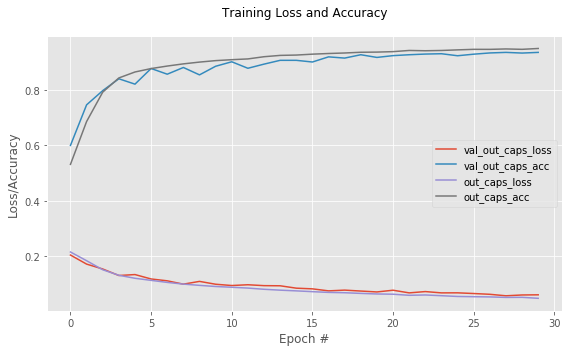

Model scores at end of training

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.061    | 0.937    | 0.949     | 0.924    | 0.936   

Best model (min val loss) scores

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.057    | 0.935    | 0.952     | 0.917    | 0.934   



In [0]:
kernels = [[7,9], 
           [9,9]]

f_size=[4,8]
frac = 100

for k_size in kernels:
    print("-------------------------------")
    print("Testing with kernel sizes {}/{}".format(k_size[0],k_size[1]))
    print("-------------------------------")
    (model, scores), hist = CapsTest(k_size, 
                                    frac=frac, 
                                    bs=BATCH_SIZE, 
                                    epochs=EPOCHS//2, 
                                    plot=True, 
                                    mshow=True,
                                    es=False,
                                    sc=2,
                                    f_sizes=f_size,
                                    bestFile="7_CapsnetModel_test.h5",
                                    pltFile="7_CapsnetModel_{}_{}_frac{}.png".format(k_size, 
                                                                                     f_size,
                                                                                     frac))
    print("Model scores at end of training")
    showScores(scores)
    print("")
    print("Best model (min val loss) scores")
    try:
        model.load_weights("7_CapsnetModel_test.h5")
        showModelScores(model, test_X, test_Y)
    except:
        pass
    print("")  

-------------------------------
Testing with kernel sizes 5/11
-------------------------------
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 44, 44, 3)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 40, 40, 4)    304         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 15, 15, 8)    3880        conv1[0][0]                      
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 225, 8)       0           conv2d_1[0][0]                   
______________

22321/22321 [==============================] - 15s 664us/step - loss: 0.0545 - out_caps_loss: 0.0545 - out_recon_loss: 0.0337 - out_caps_acc: 0.9416 - out_recon_acc: 0.5114 - val_loss: 0.0690 - val_out_caps_loss: 0.0690 - val_out_recon_loss: 0.0346 - val_out_caps_acc: 0.9291 - val_out_recon_acc: 0.5081
Epoch 17/30
22321/22321 [==============================] - 15s 671us/step - loss: 0.0534 - out_caps_loss: 0.0534 - out_recon_loss: 0.0337 - out_caps_acc: 0.9419 - out_recon_acc: 0.5109 - val_loss: 0.0605 - val_out_caps_loss: 0.0605 - val_out_recon_loss: 0.0345 - val_out_caps_acc: 0.9343 - val_out_recon_acc: 0.5075
Epoch 18/30
22321/22321 [==============================] - 15s 669us/step - loss: 0.0509 - out_caps_loss: 0.0509 - out_recon_loss: 0.0337 - out_caps_acc: 0.9437 - out_recon_acc: 0.5107 - val_loss: 0.0671 - val_out_caps_loss: 0.0671 - val_out_recon_loss: 0.0343 - val_out_caps_acc: 0.9166 - val_out_recon_acc: 0.5066
Epoch 19/30
22321/22321 [==============================] - 15s 6

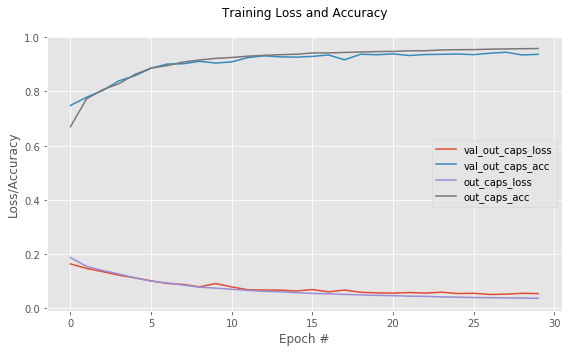

Model scores at end of training

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.055    | 0.935    | 0.920     | 0.953    | 0.936   

Best model (min val loss) scores

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.053    | 0.934    | 0.922     | 0.948    | 0.935   

-------------------------------
Testing with kernel sizes 5/13
-------------------------------
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 44, 44, 3)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 4

22321/22321 [==============================] - 15s 665us/step - loss: 0.0551 - out_caps_loss: 0.0551 - out_recon_loss: 0.0338 - out_caps_acc: 0.9295 - out_recon_acc: 0.5129 - val_loss: 0.0519 - val_out_caps_loss: 0.0519 - val_out_recon_loss: 0.0345 - val_out_caps_acc: 0.9351 - val_out_recon_acc: 0.5093
Epoch 16/30
22321/22321 [==============================] - 15s 670us/step - loss: 0.0530 - out_caps_loss: 0.0530 - out_recon_loss: 0.0338 - out_caps_acc: 0.9327 - out_recon_acc: 0.5128 - val_loss: 0.0584 - val_out_caps_loss: 0.0583 - val_out_recon_loss: 0.0344 - val_out_caps_acc: 0.9194 - val_out_recon_acc: 0.5087
Epoch 17/30
22321/22321 [==============================] - 15s 673us/step - loss: 0.0500 - out_caps_loss: 0.0500 - out_recon_loss: 0.0337 - out_caps_acc: 0.9358 - out_recon_acc: 0.5123 - val_loss: 0.0566 - val_out_caps_loss: 0.0566 - val_out_recon_loss: 0.0344 - val_out_caps_acc: 0.9279 - val_out_recon_acc: 0.5085
Epoch 18/30
22321/22321 [==============================] - 15s 6

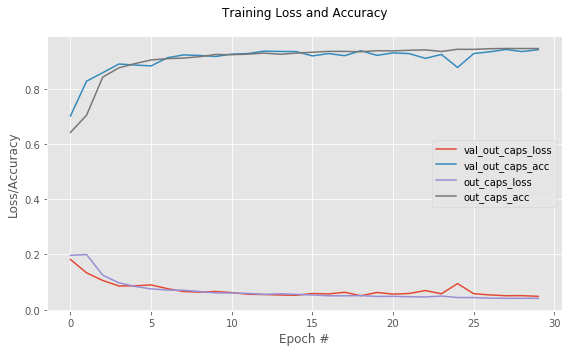

Model scores at end of training

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.046    | 0.946    | 0.958     | 0.932    | 0.945   

Best model (min val loss) scores

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.046    | 0.946    | 0.958     | 0.932    | 0.945   



In [0]:
kernels = [[5,11],
           [5,13]]

f_size=[4,8]
frac = 100

for k_size in kernels:
    print("-------------------------------")
    print("Testing with kernel sizes {}/{}".format(k_size[0],k_size[1]))
    print("-------------------------------")
    (model, scores), hist = CapsTest(k_size, 
                                    frac=frac, 
                                    bs=BATCH_SIZE, 
                                    epochs=EPOCHS//2, 
                                    plot=True, 
                                    mshow=True,
                                    sc=2,
                                    es=False,
                                    f_sizes=f_size,
                                    bestFile="7_CapsnetModel_test.h5",
                                    pltFile="7_CapsnetModel_{}_{}_frac{}.png".format(k_size, 
                                                                                     f_size,
                                                                                     frac))
    print("Model scores at end of training")
    showScores(scores)
    print("")
    print("Best model (min val loss) scores")
    try:
        model.load_weights("7_CapsnetModel_test.h5")
        showModelScores(model, test_X, test_Y)
    except:
        pass
    print("") 

-------------------------------
Testing with kernel sizes 7/11
-------------------------------
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 44, 44, 3)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 38, 38, 4)    592         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 8)    3880        conv1[0][0]                      
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 196, 8)       0           conv2d_1[0][0]                   
______________

22321/22321 [==============================] - 16s 705us/step - loss: 0.0555 - out_caps_loss: 0.0554 - out_recon_loss: 0.0333 - out_caps_acc: 0.9349 - out_recon_acc: 0.5099 - val_loss: 0.0591 - val_out_caps_loss: 0.0591 - val_out_recon_loss: 0.0338 - val_out_caps_acc: 0.9331 - val_out_recon_acc: 0.5064
Epoch 17/30
22321/22321 [==============================] - 16s 702us/step - loss: 0.0551 - out_caps_loss: 0.0551 - out_recon_loss: 0.0330 - out_caps_acc: 0.9324 - out_recon_acc: 0.5100 - val_loss: 0.0597 - val_out_caps_loss: 0.0597 - val_out_recon_loss: 0.0335 - val_out_caps_acc: 0.9266 - val_out_recon_acc: 0.5067
Epoch 18/30
22321/22321 [==============================] - 16s 704us/step - loss: 0.0513 - out_caps_loss: 0.0513 - out_recon_loss: 0.0328 - out_caps_acc: 0.9401 - out_recon_acc: 0.5105 - val_loss: 0.0683 - val_out_caps_loss: 0.0683 - val_out_recon_loss: 0.0334 - val_out_caps_acc: 0.9182 - val_out_recon_acc: 0.5069
Epoch 19/30
22321/22321 [==============================] - 16s 7

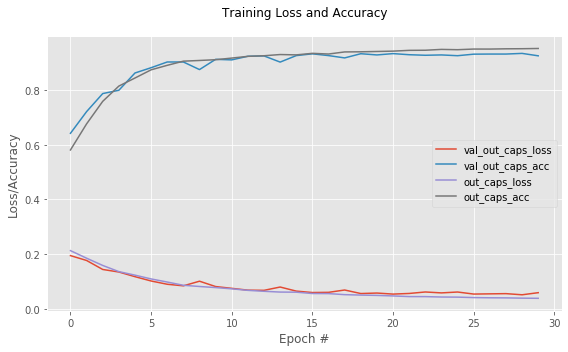

Model scores at end of training

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.061    | 0.920    | 0.911     | 0.931    | 0.921   

Best model (min val loss) scores

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.055    | 0.929    | 0.939     | 0.917    | 0.928   

-------------------------------
Testing with kernel sizes 7/13
-------------------------------
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 44, 44, 3)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 3

22321/22321 [==============================] - 16s 724us/step - loss: 0.0680 - out_caps_loss: 0.0680 - out_recon_loss: 0.0337 - out_caps_acc: 0.9265 - out_recon_acc: 0.5114 - val_loss: 0.0683 - val_out_caps_loss: 0.0682 - val_out_recon_loss: 0.0344 - val_out_caps_acc: 0.9315 - val_out_recon_acc: 0.5073
Epoch 16/30
22321/22321 [==============================] - 16s 722us/step - loss: 0.0638 - out_caps_loss: 0.0638 - out_recon_loss: 0.0337 - out_caps_acc: 0.9319 - out_recon_acc: 0.5109 - val_loss: 0.0684 - val_out_caps_loss: 0.0684 - val_out_recon_loss: 0.0344 - val_out_caps_acc: 0.9226 - val_out_recon_acc: 0.5069
Epoch 17/30
22321/22321 [==============================] - 16s 725us/step - loss: 0.0611 - out_caps_loss: 0.0611 - out_recon_loss: 0.0337 - out_caps_acc: 0.9354 - out_recon_acc: 0.5107 - val_loss: 0.0666 - val_out_caps_loss: 0.0666 - val_out_recon_loss: 0.0343 - val_out_caps_acc: 0.9246 - val_out_recon_acc: 0.5072
Epoch 18/30
22321/22321 [==============================] - 16s 7

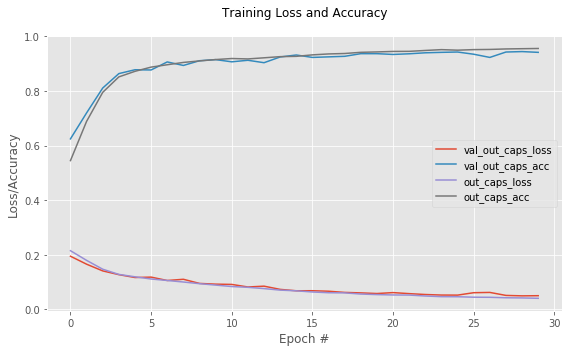

Model scores at end of training

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.051    | 0.940    | 0.944     | 0.935    | 0.940   

Best model (min val loss) scores

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.050    | 0.945    | 0.962     | 0.927    | 0.944   



In [0]:
kernels = [[7,11],
           [7,13]]

f_size=[4,8]
frac = 100

for k_size in kernels:
    print("-------------------------------")
    print("Testing with kernel sizes {}/{}".format(k_size[0],k_size[1]))
    print("-------------------------------")
    (model, scores), hist = CapsTest(k_size, 
                                    frac=frac, 
                                    bs=BATCH_SIZE, 
                                    epochs=EPOCHS//2, 
                                    plot=True, 
                                    mshow=True,
                                    sc=2,
                                    es=False,
                                    f_sizes=f_size,
                                    bestFile="7_CapsnetModel_test.h5",
                                    pltFile="7_CapsnetModel_{}_{}_frac{}.png".format(k_size, 
                                                                                     f_size,
                                                                                     frac))
    print("Model scores at end of training")
    showScores(scores)
    print("")
    print("Best model (min val loss) scores")
    try:
        model.load_weights("7_CapsnetModel_test.h5")
        showModelScores(model, test_X, test_Y)
    except:
        pass
    print("")  

-------------------------------
Testing with kernel sizes 9/11
-------------------------------
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 44, 44, 3)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 36, 36, 4)    976         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 13, 13, 8)    3880        conv1[0][0]                      
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 169, 8)       0           conv2d_1[0][0]                   
______________

22321/22321 [==============================] - 16s 739us/step - loss: 0.0757 - out_caps_loss: 0.0757 - out_recon_loss: 0.0337 - out_caps_acc: 0.9197 - out_recon_acc: 0.5104 - val_loss: 0.0894 - val_out_caps_loss: 0.0894 - val_out_recon_loss: 0.0344 - val_out_caps_acc: 0.8992 - val_out_recon_acc: 0.5060
Epoch 17/30
22321/22321 [==============================] - 17s 740us/step - loss: 0.0733 - out_caps_loss: 0.0733 - out_recon_loss: 0.0337 - out_caps_acc: 0.9208 - out_recon_acc: 0.5101 - val_loss: 0.0788 - val_out_caps_loss: 0.0788 - val_out_recon_loss: 0.0344 - val_out_caps_acc: 0.9166 - val_out_recon_acc: 0.5068
Epoch 18/30
22321/22321 [==============================] - 17s 742us/step - loss: 0.0717 - out_caps_loss: 0.0717 - out_recon_loss: 0.0337 - out_caps_acc: 0.9217 - out_recon_acc: 0.5099 - val_loss: 0.0773 - val_out_caps_loss: 0.0773 - val_out_recon_loss: 0.0344 - val_out_caps_acc: 0.9089 - val_out_recon_acc: 0.5065
Epoch 19/30
22321/22321 [==============================] - 16s 7

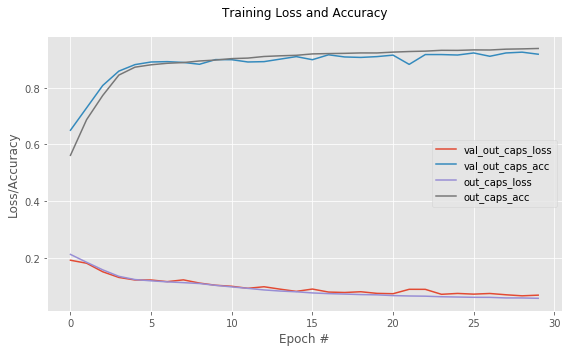

Model scores at end of training

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.067    | 0.924    | 0.928     | 0.919    | 0.923   

Best model (min val loss) scores

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.064    | 0.926    | 0.938     | 0.913    | 0.925   



In [0]:
kernels = [[9,11]]

f_size=[4,8]
frac = 100

for k_size in kernels:
    print("-------------------------------")
    print("Testing with kernel sizes {}/{}".format(k_size[0],k_size[1]))
    print("-------------------------------")
    (model, scores), hist = CapsTest(k_size, 
                                    frac=frac, 
                                    bs=BATCH_SIZE, 
                                    epochs=EPOCHS//2, 
                                    plot=True, 
                                    mshow=True,
                                    sc=2,
                                    es=False,
                                    f_sizes=f_size,
                                    bestFile="7_CapsnetModel_test.h5",
                                    pltFile="7_CapsnetModel_{}_{}_frac{}.png".format(k_size, 
                                                                                     f_size,
                                                                                     frac))
    print("Model scores at end of training")
    showScores(scores)
    print("")
    print("Best model (min val loss) scores")
    try:
        model.load_weights("7_CapsnetModel_test.h5")
        showModelScores(model, test_X, test_Y)
    except:
        pass
    print("")  

-------------------------------
Testing with kernel sizes 9/13
-------------------------------
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           (None, 44, 44, 3)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 36, 36, 4)    976         input_19[0][0]                   
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 12, 12, 8)    5416        conv1[0][0]                      
__________________________________________________________________________________________________
reshape_10 (Reshape)            (None, 144, 8)       0           conv2d_10[0][0]                  
______________

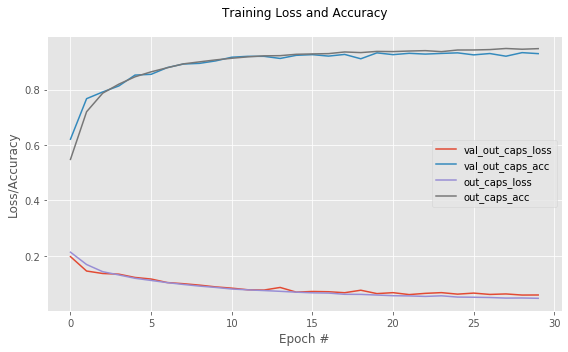

Model scores at end of training

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.060    | 0.926    | 0.927     | 0.924    | 0.925   

Best model (min val loss) scores

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.061    | 0.924    | 0.929     | 0.919    | 0.924   



In [0]:
kernels = [[9,13]]

f_size=[4,8]
frac = 100

for k_size in kernels:
    print("-------------------------------")
    print("Testing with kernel sizes {}/{}".format(k_size[0],k_size[1]))
    print("-------------------------------")
    (model, scores), hist = CapsTest(k_size, 
                                    frac=frac, 
                                    bs=BATCH_SIZE, 
                                    epochs=EPOCHS//2, 
                                    plot=True, 
                                    mshow=True,
                                    sc=2,
                                    es=True,
                                    f_sizes=f_size,
                                    bestFile="7_CapsnetModel_test.h5",
                                    pltFile="7_CapsnetModel_{}_{}_frac{}.png".format(k_size, 
                                                                                     f_size,
                                                                                     frac))
    print("Model scores at end of training")
    showScores(scores)
    print("")
    print("Best model (min val loss) scores")
    try:
        model.load_weights("7_CapsnetModel_test.h5")
        showModelScores(model, test_X, test_Y)
    except:
        pass
    print("")  

##11 Save models and images

In [0]:
%%bash
cp -f ./*.h5 "$GPATH/Models"
cp -f ./*.json "$GPATH/Models"
cp -f ./7_*.png "$GPATH/Images"

cp: cannot stat './*.json': No such file or directory
